In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

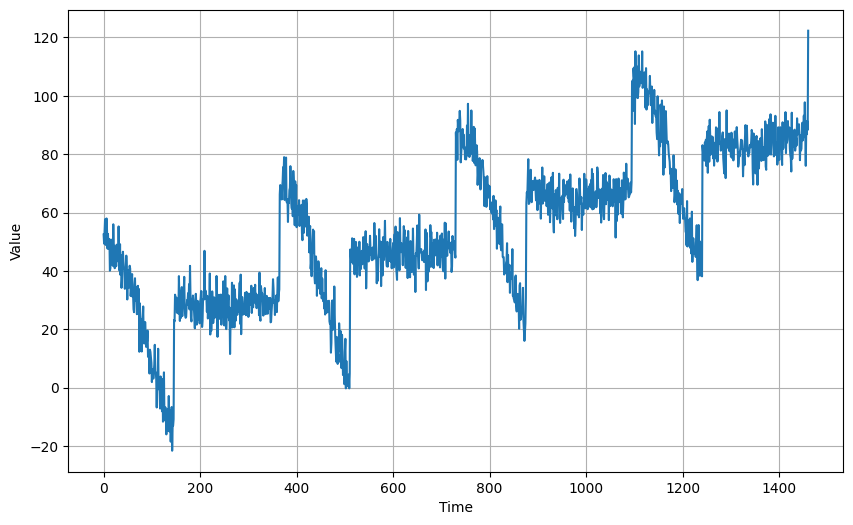

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [1]:
x_train = tf.expand_dims(x_train,axis=-1)

NameError: name 'tf' is not defined

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)



model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - 3s 28ms/step - loss: 35.9469 - mae: 36.4454 - val_loss: 24.9544 - val_mae: 25.4525
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 10.3430 - mae: 10.8285 - val_loss: 11.3997 - val_mae: 11.8879
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 9.3146 - mae: 9.8016 - val_loss: 8.8563 - val_mae: 9.3411
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 9.1158 - mae: 9.6056 - val_loss: 8.7338 - val_mae: 9.2231
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 8.8066 - mae: 9.2966 - val_loss: 8.4628 - val_mae: 8.9496
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 8.6060 - mae: 9.0959 - val_loss: 8.5579 - val_mae: 9.0452
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 8.4822 - mae: 8.9705 - val_loss: 8.1720 - val_mae: 8.6599
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 8.3689 - mae:

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 32.5720 - mae: 33.0703 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 19.6980 - mae: 20.1912 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 12.3562 - mae: 12.8487 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 11.8390 - mae: 12.3281 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 11.7705 - mae: 12.2595 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 11.6971 - mae: 12.1869 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 11.6256 - mae: 12.1127 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 11.5472 - mae: 12.0353 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 11.4605 - mae: 11.9464 

(1e-06, 0.001, 0.0, 20.0)

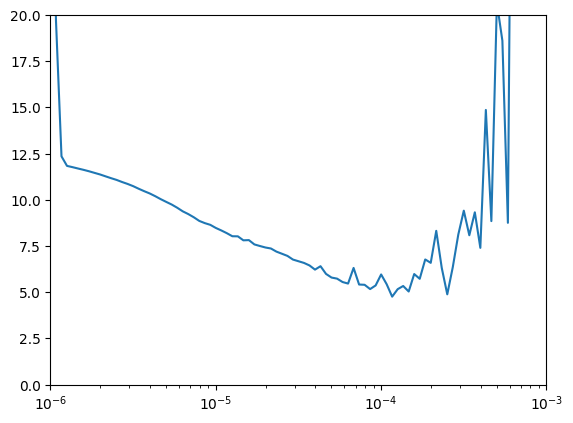

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 11.6301 - mae: 12.1222 - val_loss: 9.8488 - val_mae: 10.3365
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 7.6251 - mae: 8.1128 - val_loss: 6.9049 - val_mae: 7.3900
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.4201 - mae: 7.9062 - val_loss: 7.0436 - val_mae: 7.5258
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 7.4168 - mae: 7.9011 - val_loss: 7.0890 - val_mae: 7.5728
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 7.3176 - mae: 7.8008 - val_loss: 7.0626 - val_mae: 7.5448
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 7.2451 - mae: 7.7287 - val_loss: 6.7713 - val_mae: 7.2599
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.1620 - mae: 7.6454 - val_loss: 6.5875 - val_mae: 7.0720
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 7.0634

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


In [12]:
lin_forecast.shape

(461,)

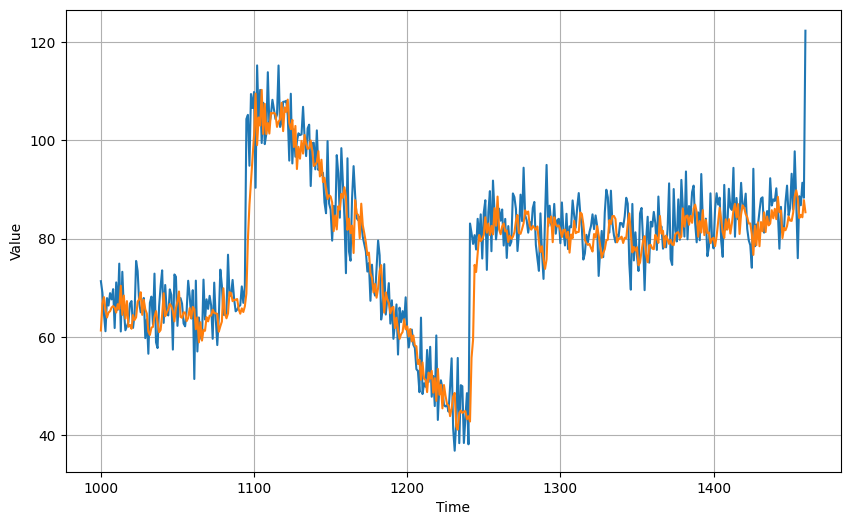

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.975355

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 70.3097 - mae: 70.8097 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 69.3529 - mae: 69.8529 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 68.2072 - mae: 68.7072 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 66.9341 - mae: 67.4337 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 65.5304 - mae: 66.0299 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 63.9727 - mae: 64.4726 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 62.2539 - mae: 62.7539 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 60.3533 - mae: 60.8533 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 58.2764 - mae: 58.7764 

(1e-07, 0.005, 0.0, 30.0)

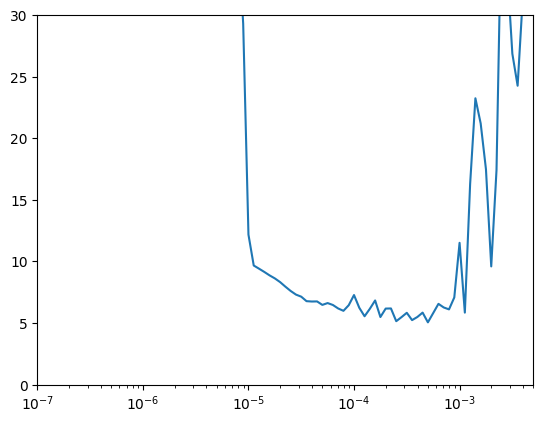

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 6.7845 - mae: 7.2662 - val_loss: 7.7106 - val_mae: 8.1981
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 6.4386 - mae: 6.9213 - val_loss: 6.2486 - val_mae: 6.7314
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 6.2682 - mae: 6.7498 - val_loss: 5.9567 - val_mae: 6.4445
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 6.1682 - mae: 6.6530 - val_loss: 6.0847 - val_mae: 6.5629
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 6.0884 - mae: 6.5714 - val_loss: 5.4933 - val_mae: 5.9744
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 6.0366 - mae: 6.5188 - val_loss: 5.8613 - val_mae: 6.3386
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 6.0356 - mae: 6.5196 - val_loss: 5.4532 - val_mae: 5.9345
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 6.0083 - 

In [18]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


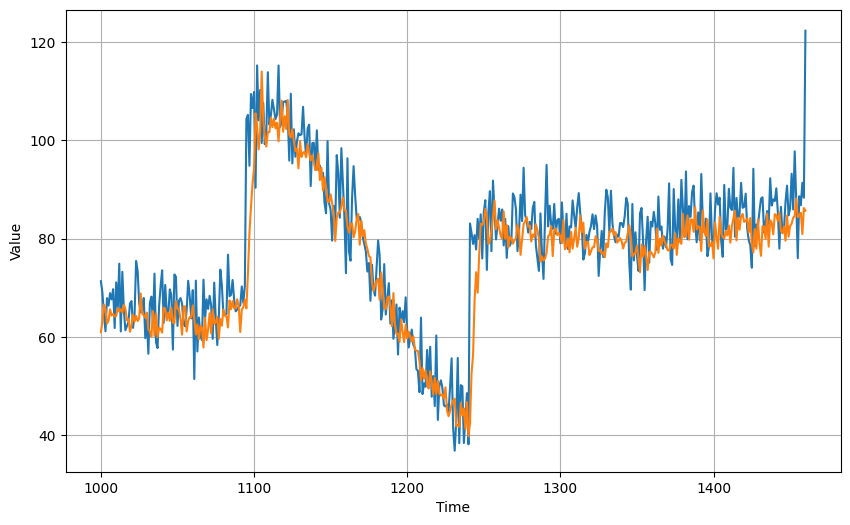

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.311761